# Laboratorio di Simulazione Numerica: esercizio 11.2

Elia steve (47122A)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

2024-09-17 09:48:20.782690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In questo esercizio dobbiamo usare una rete neurale per eseguire un fit di dati che seguono la legge polinomiale

$$
y=4-3x-2x^2+3x^3,\quad
x\in[-1, 1].
$$

Creo dati di training, validazione (introduco rumore gaussiano con larghezza $\sigma=0.05$).

In [2]:
rng = np.random.default_rng(seed=42)
keras.utils.set_random_seed(42)

coeff = [3, -2, -3, 4]
n_train = 1000
n_test = 200

x_train = rng.uniform(-1, 1, n_train)
x_train.sort()
y_train = np.polyval(coeff, x_train) + rng.normal(0, 0.05, n_train)
x_test = rng.uniform(-1, 1, n_test)
y_test = np.polyval(coeff, x_test) + rng.normal(0, 0.05, n_test)

x_pred = rng.uniform(-1, 1, 500)
x_pred.sort()

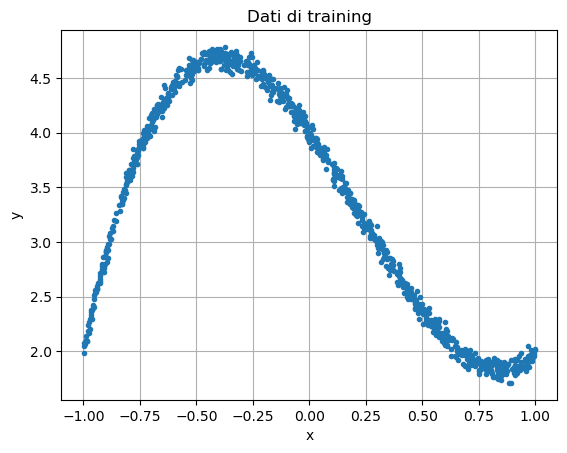

In [3]:
plt.plot(x_train, y_train, ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dati di training")
plt.grid(True)

Cominciamo usando un modello relativamente semplice e con pochi parametri, ma addestrato per 700 epoche. Ottimizziamo questo modello e tutti i successivi con la discesa stocastica del gradiente, e scegliamo come funzione di costo l'errore quadratico medio.

In [4]:
model_simple = tf.keras.Sequential()
model_simple.add(Dense(8, input_shape=(1, ), activation="tanh"))
model_simple.add(Dense(1))

2024-09-17 09:48:24.052815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 16        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_simple.compile(
    optimizer="sgd",
    loss=keras.losses.MeanSquaredError(),
)

In [7]:
history_simple = model_simple.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=700,
    validation_data=(x_test, y_test)
)

Epoch 1/700
32/32 [==============================] - 0s 6ms/step - loss: 4.1414 - val_loss: 0.9117
Epoch 2/700
32/32 [==============================] - 0s 2ms/step - loss: 0.5474 - val_loss: 0.5016
Epoch 3/700
32/32 [==============================] - 0s 2ms/step - loss: 0.4085 - val_loss: 0.4502
Epoch 4/700
32/32 [==============================] - 0s 2ms/step - loss: 0.3763 - val_loss: 0.4316
Epoch 5/700
32/32 [==============================] - 0s 2ms/step - loss: 0.3623 - val_loss: 0.4177
Epoch 6/700
32/32 [==============================] - 0s 2ms/step - loss: 0.3500 - val_loss: 0.4044
Epoch 7/700
32/32 [==============================] - 0s 2ms/step - loss: 0.3380 - val_loss: 0.3911
Epoch 8/700
32/32 [==============================] - 0s 2ms/step - loss: 0.3262 - val_loss: 0.3770
Epoch 9/700
32/32 [==============================] - 0s 2ms/step - loss: 0.3143 - val_loss: 0.3683
Epoch 10/700
32/32 [==============================] - 0s 3ms/step - loss: 0.3027 - val_loss: 0.3565
Epoch 11/

In [8]:
print("Funzione costo dopo l'adestramento:", model_simple.evaluate(x_test, y_test, batch_size=32, verbose=1))

7/7 [==============================] - 0s 1ms/step - loss: 0.0078
Funzione costo dopo l'adestramento: 0.007788586430251598


Disegno un grafico della funzione costo calcolata per i dati di training e di validazione in funzione dell'epoca:

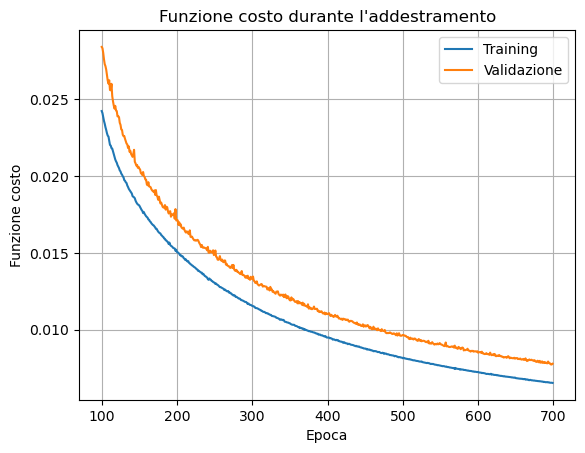

In [9]:
# summarize history for loss
plt.plot(np.arange(100, 700), history_simple.history['loss'][100:])
plt.plot(np.arange(100, 700), history_simple.history['val_loss'][100:])
plt.ylabel('Funzione costo')
plt.xlabel('Epoca')
plt.title("Funzione costo durante l'addestramento")
plt.legend(['Training', 'Validazione'], loc='best')
plt.grid()
plt.show()

Vediamo il comportamento che ci aspettiamo: la funzone costo decresce con l'epoca in entrambi i casi (segno che non siamo andati in overtraining), e la funzione costo per i dati di validazione è maggiore di quella per i dati di training. Ora testo le previsioni del modello:

16/16 [==============================] - 0s 1ms/step


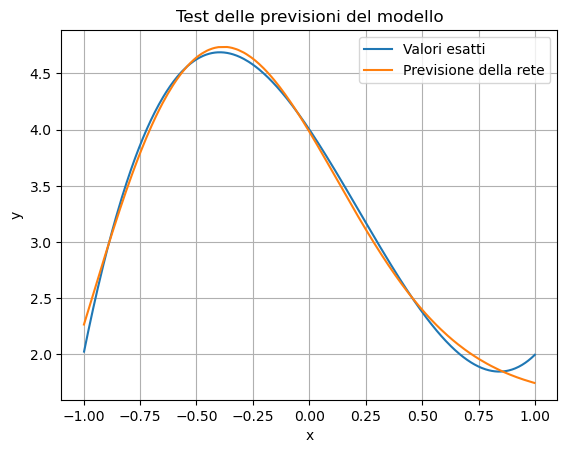

In [10]:
y_pred_simple = model_simple.predict(x_pred)

plt.plot(x_train, np.polyval(coeff, x_train), label="Valori esatti")
plt.plot(x_pred, y_pred_simple, label="Previsione della rete")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test delle previsioni del modello")
plt.legend()
plt.grid(True)

Vediamo che il modello riesce ad approssimare discretamente il polinomio. Ora proviamo a usare un modello più complicato, ma addestrato per meno tempo. Creo e addestro il modello: 

In [11]:
model_tanh = tf.keras.Sequential()
model_tanh.add(Dense(8, input_shape=(1, ), activation="tanh"))
model_tanh.add(Dense(8, activation="tanh"))
model_tanh.add(Dense(8, activation="tanh"))
model_tanh.add(Dense(8, activation="tanh"))
model_tanh.add(Dense(1))

In [12]:
model_tanh.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 16        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_tanh.compile(
    optimizer="sgd",
    loss=keras.losses.MeanSquaredError(),
)

In [14]:
history_tanh = model_tanh.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_test, y_test)
)

Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 1.4979 - val_loss: 0.4006
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.3035 - val_loss: 0.3373
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2718 - val_loss: 0.3110
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2414 - val_loss: 0.2751
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2399
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1837 - val_loss: 0.2010
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.1518 - val_loss: 0.1696
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1264 - val_loss: 0.1389
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.1131
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0859 - val_loss: 0.1038
Epoch 11/

In [15]:
print("Funzione costo dopo l'adestramento:", model_tanh.evaluate(x_test, y_test, batch_size=32, verbose=1))

7/7 [==============================] - 0s 1ms/step - loss: 0.0072
Funzione costo dopo l'adestramento: 0.007164007518440485


Vediamo che la funzione costo del modello è più bassa di quella del modello precedente. Siccome a questo livello sembra che non ci sia una differenza significativa nel tempo per la singola epoca, è conveniente usare più parametri e ridurre le epoche. Disegno un grafico della funzione costo calcolata per i dati di training e di validazione in funzione dell'epoca:

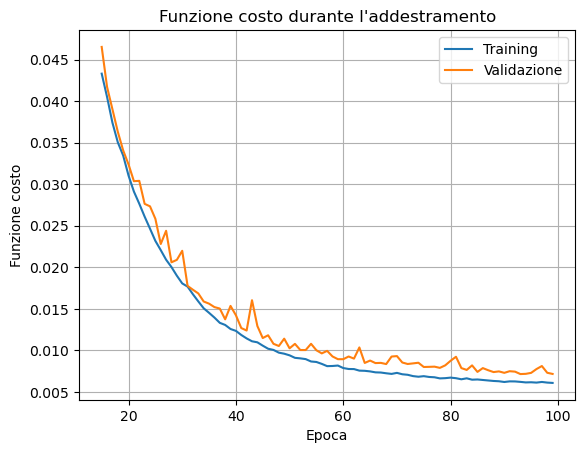

In [27]:
# summarize history for loss
plt.plot(np.arange(15, 100), history_tanh.history['loss'][15:])
plt.plot(np.arange(15, 100), history_tanh.history['val_loss'][15:])
plt.ylabel('Funzione costo')
plt.xlabel('Epoca')
plt.legend(['Training', 'Validazione'], loc='best')
plt.title("Funzione costo durante l'addestramento")
plt.grid()
plt.show()

Anche qui il comportamento è quello che ci aspettiamo. Ora testo le previsioni del modello:

16/16 [==============================] - 0s 1ms/step


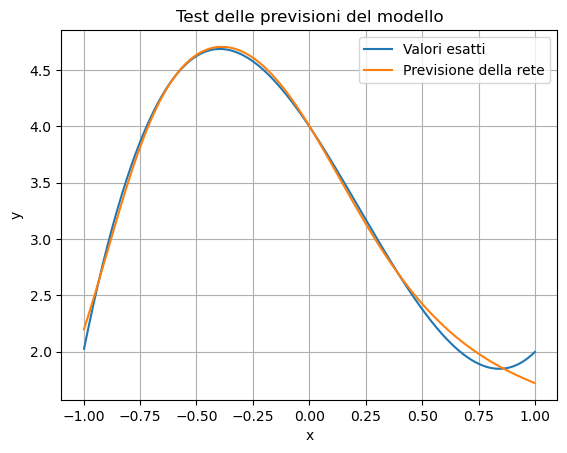

In [17]:
y_pred_tanh = model_tanh.predict(x_pred)

plt.plot(x_train, np.polyval(coeff, x_train), label="Valori esatti")
plt.plot(x_pred, y_pred_tanh, label="Previsione della rete")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test delle previsioni del modello")
plt.legend()
plt.grid(True)

Vediamo che le previsioni sono analoghe a quelle del modello precedente. Ora provo a usare la relu come funzione di attivatione, invece della tangente iperbolica. Definisco, addestro il modello:

In [18]:
model_relu = tf.keras.Sequential()
model_relu.add(Dense(8, input_shape=(1, ), activation="relu"))
model_relu.add(Dense(8, activation="relu"))
model_relu.add(Dense(8, activation="relu"))
model_relu.add(Dense(8, activation="relu"))
model_relu.add(Dense(1))

In [19]:
model_relu.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 16        
                                                                 
 dense_8 (Dense)             (None, 8)                 72        
                                                                 
 dense_9 (Dense)             (None, 8)                 72        
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_relu.compile(
    optimizer="sgd",
    loss=keras.losses.MeanSquaredError(),
)

In [ ]:
history_relu = model_relu.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_test, y_test)
)

In [22]:
print("Funzione costo dopo l'adestramento:", model_relu.evaluate(x_test, y_test, batch_size=32, verbose=1))

7/7 [==============================] - 0s 1ms/step - loss: 0.0050
Funzione costo dopo l'adestramento: 0.005037425551563501


Osserviamo che la funzione costo migliora rispetto ai precedenti modelli, anche se l'ordine di grandezza è analogo. Disegno il grafico della funzione costo:

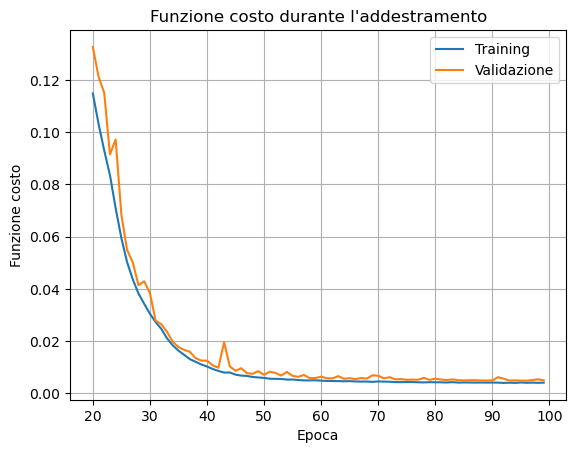

In [28]:
# summarize history for loss
plt.plot(np.arange(20, 100), history_relu.history['loss'][20:])
plt.plot(np.arange(20, 100), history_relu.history['val_loss'][20:])
plt.ylabel('Funzione costo')
plt.xlabel('Epoca')
plt.legend(['Training', 'Validazione'], loc='best')
plt.title("Funzione costo durante l'addestramento")
plt.grid()
plt.show()

Anche qui il coportamento è quello che ci aspettiamo. Testo le previsioni del modello:

16/16 [==============================] - 0s 1ms/step


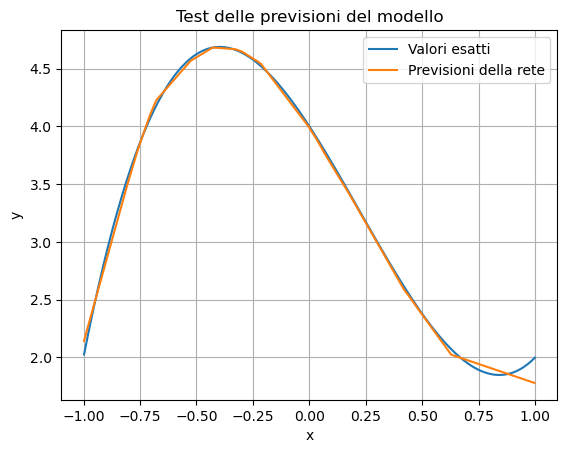

In [29]:
y_pred_relu = model_relu.predict(x_pred)

plt.plot(x_train, np.polyval(coeff, x_train), label="Valori esatti")
plt.plot(x_pred, y_pred_relu, label="Previsioni della rete")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test delle previsioni del modello")
plt.legend()
plt.grid(True)

Anche qui le previsioni sono analghe ai modelli precedenti e approssimano discretamente il polinomio. Ora testo le previsioni del modello sull'intervallo $[-3/2,3/2]$, che è più grande di quello su cui è stato addestrato.

16/16 [==============================] - 0s 1ms/step


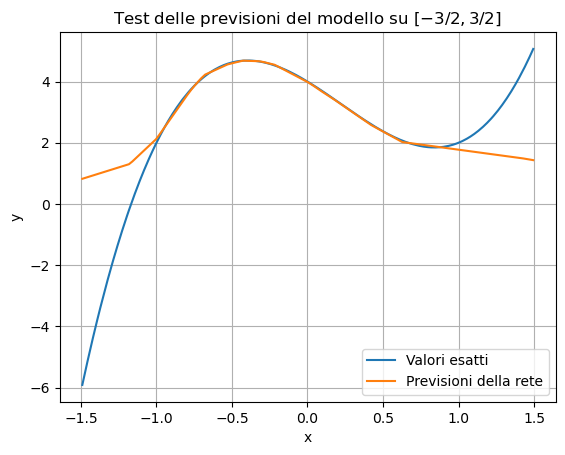

In [31]:
x_pred_outside = rng.uniform(-1.5, 1.5, 500)
x_pred_outside.sort()
y_pred_outside = model_relu.predict(x_pred_outside)

plt.plot(x_pred_outside, np.polyval(coeff, x_pred_outside), label="Valori esatti")
plt.plot(x_pred_outside, y_pred_outside, label="Previsioni della rete")
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"Test delle previsioni del modello su $[-3/2, 3/2]$")
plt.legend()
plt.grid(True)

Qui vediamo che le previsoni del modello fuori dall'intervallo in cui è stato addestrato sono molto diverse dal polinomio. In conclusione osserviamo che in generale l'aumento della complessità del modello, e quindi della sua capacità rappresentativa, produce un fit migliore dei dati di addestramento. Questo miglioramento, però, non si traduce necessariamente in un miglioramento della capacità predittiva del modello rispetto a dati nuovi, che al crescere delle epoche di addestramento può rimanere costante o addirittura peggiorare (il fenomento dell'_overtraining_, che qui non abbiamo visto). Inoltre, una buona capacità predittiva su dati dello stesso tipo di quelli usati durante l'addstramento non significa che il modello sarà in grado di effettuare buone previsioni su dati di tipo diverso (nel nostro caso confronta le previsioni se $x\in[-1, 1]$ con quelle se $x\in[-3/2, 3/2]$).